# Как улучшить ретурн: добавить плечо

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
from tqdm.notebook import tqdm
from numpy_ext import rolling_apply

import matplotlib.pyplot as plt

## Загрузка данных

In [2]:
df = pd.read_csv('../csv/SBER_101001_201001_1d.csv',
		delimiter=',',
		parse_dates=[[0,1]],
		index_col=0,
		names=['Date','Time','Open', 'High', 'Low', 'Close', 'Volume'],
		header=0,
		encoding='utf-8'
	)

## Подготовка данных

In [3]:
# Определяет цвета свечей
df['Color'] = np.where(
    df['Open']<df['Close'],
    'Up',
    np.where(
        df['Open']>df['Close'],
        'Down',
        'Dodge'
    )
)

In [4]:
def add_buy_and_sell_prev_close(df):
    buy = df[['Close']].rename(columns={"Close": "Buy"})
    buy['Buy'] = df['Close'].apply(np.log)-df['Open'].apply(np.log)
    #buy['Buy_Prev_Close'] = df['Close'].apply(np.log)-df['Close'].shift(1).apply(np.log)
    #buy['Buy_'] = (df['Close']-df['Open'])/df['Open']
    df = df.join(buy)

    sell = df[['Close']].rename(columns={"Close": "Sell"})
    sell['Sell'] = df['Open'].apply(np.log)-df['Close'].apply(np.log)
    #sell['Sell_Prev_Close'] = df['Close'].shift(1).apply(np.log)-df['Close'].apply(np.log)
    #sell['Sell_'] = (df['Open']-df['Close'])/df['Open']
    df = df.join(sell)

    return df

In [5]:
df = add_buy_and_sell_prev_close(df)

In [6]:
def calc_n_days_buy(color, buy):
    """Проверяет есть ли n дней подряд закрытия вверх.

    Args:
		color [list of str]: массив, где каждый элемент показывает цвет свечи 'Up' или 'Down'
        buy [list of float]: массив с покупками

	Returns:
		[float]: разница в % между текущей и предыдущей ценой при покупке (или NaN)
    """
    n = len(color)
    if (color[:n-1] == 'Down').all():
        return buy[-1]
    else:
        return np.nan

In [7]:
def calc_n_days_sell(color, sell):
    """Проверяет есть ли n дней подряд закрытия вниз.

    Args:
		color [list of str]: массив, где каждый элемент показывает цвет свечи 'Up' или 'Down'
        sell [list of float]: массив с продажами

	Returns:
		[float]: разница в % между текущей и предыдущей ценой при продаже (или NaN)
    """
    n = len(color)
    if (color[:n-1] == 'Up').all():
        return sell[-1]
    else:
        return np.nan

In [8]:
def calc_n_days_buysell(color, buy, sell):
    """Проверяет есть ли n дней подряд закрытия вверх или закрытия вниз для продаж и покупок вместе

    Args:
		color [list of str]: массив, где каждый элемент показывает цвет свечи 'Up' или 'Down'
        buy [list of float]: массив с покупками
        sell [list of float]: массив с продажами
	Returns:
		[float]: разница в % между текущей и предыдущей ценой при покупке или продаже (или NaN)
    """
    n = len(color)
    if (color[:n-1] == 'Down').all():
        return buy[-1]
    elif (color[:n-1] == 'Up').all():
        return sell[-1]
    else:
        return np.nan

## Основной цикл

In [9]:
def direct(df, commission, days):
    for n in tqdm(range(1,days)):
        buy_n_days = 'Buy_'+str(n)+'_Days'
        sell_n_days = 'Sell_'+str(n)+'_Days'
        buysell_n_days = 'Buysell_'+str(n)+'_Days'
        
        equity_buy = 'Equity_'+buy_n_days    
        equity_sell = 'Equity_'+sell_n_days    
        equity_buysell = 'Equity_'+buysell_n_days

        equity_buy_commiss = equity_buy+'_Commiss'
        equity_sell_commiss = equity_sell+'_Commiss'
        equity_buysell_commiss = equity_buysell+'_Commiss'

        df[buy_n_days] = rolling_apply(calc_n_days_buy, n+1, df.Color.values, df.Buy.values)
        df[sell_n_days] = rolling_apply(calc_n_days_sell, n+1, df.Color.values, df.Sell.values)
        df[buysell_n_days] = rolling_apply(calc_n_days_buysell, n+1, df.Color.values, df.Buy.values, df.Sell.values)

        #Плечо от 1 до 5
        for lever in range(1,6):
            equity_buy_lever = equity_buy+'_Lever_'+str(lever)
            equity_sell_lever = equity_sell+'_Lever_'+str(lever)
            equity_buysell_lever = equity_buysell+'_Lever_'+str(lever)

            equity_buy_commiss_lever = equity_buy_commiss+'_Lever_'+str(lever)
            equity_sell_commiss_lever = equity_sell_commiss+'_Lever_'+str(lever)
            equity_buysell_commiss_lever = equity_buysell_commiss+'_Lever_'+str(lever)

            #эквити без комиссий
            df[equity_buy_lever] = (df[buy_n_days]*lever).cumsum().apply(np.exp)
            df[equity_sell_lever] = (df[sell_n_days]*lever).cumsum().apply(np.exp)
            df[equity_buysell_lever] = (df[buysell_n_days]*lever).cumsum().apply(np.exp)

            #эквити с комиссиями
            df[equity_buy_commiss_lever] = ((df[buy_n_days]*lever)-commission/100*2).cumsum().apply(np.exp)
            df[equity_sell_commiss_lever] = ((df[sell_n_days]*lever)-commission/100*2).cumsum().apply(np.exp)
            df[equity_buysell_commiss_lever] = ((df[buysell_n_days]*lever)-commission/100*2).cumsum().apply(np.exp)
    
    return df

In [10]:
def main_loop(df):
    commission = 0.06
    days = 6 # days - количество дней, цикл считает до n-1
    df = direct(df, commission, days)
    
    return df

In [11]:
df = main_loop(df)

## Графики

In [12]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'

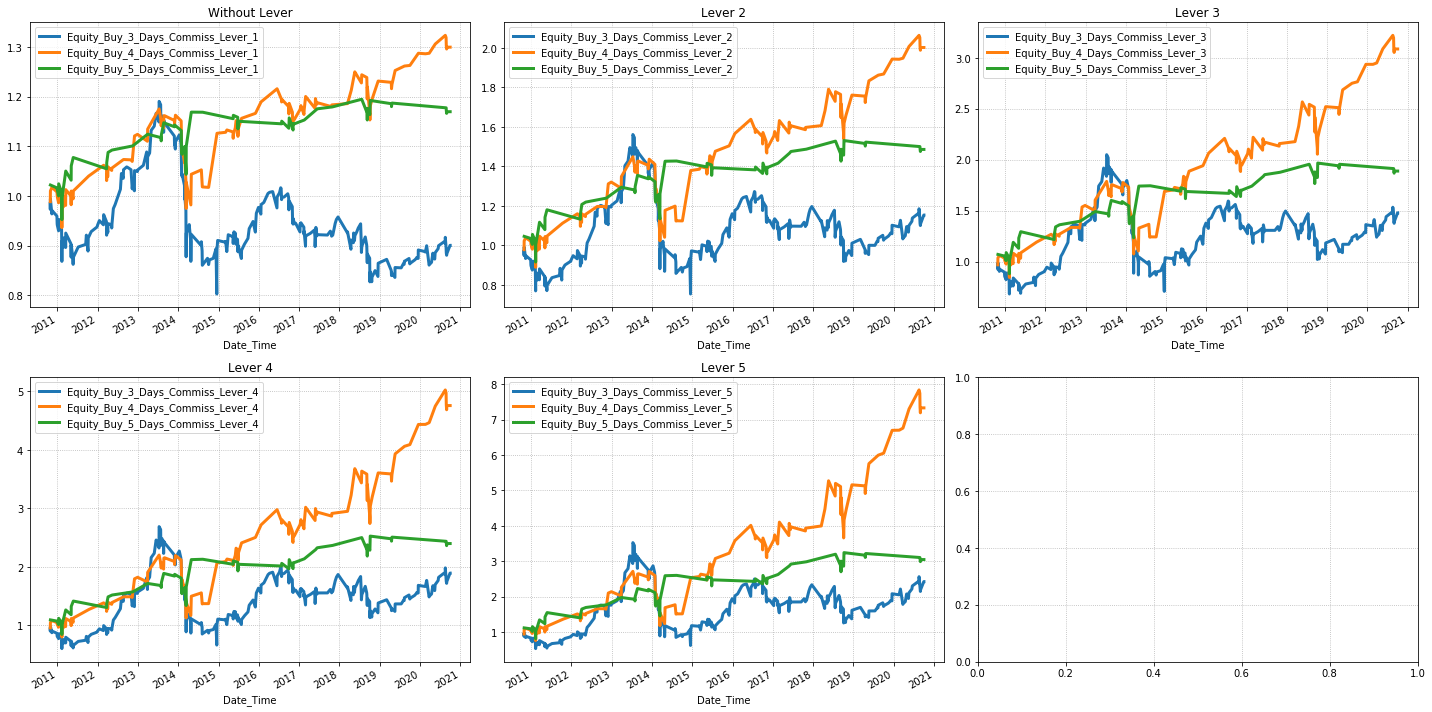

In [27]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
df[[
    #'Equity_Buy_1_Days_Commiss_Lever_1',
    #'Equity_Buy_2_Days_Commiss_Lever_1',
    'Equity_Buy_3_Days_Commiss_Lever_1',
    'Equity_Buy_4_Days_Commiss_Lever_1',
    'Equity_Buy_5_Days_Commiss_Lever_1'
]].interpolate(method='index').plot(ax=ax[0,0], title='Without Lever')
df[[
    #'Equity_Buy_1_Days_Commiss_Lever_2',
    #'Equity_Buy_2_Days_Commiss_Lever_2',
    'Equity_Buy_3_Days_Commiss_Lever_2',
    'Equity_Buy_4_Days_Commiss_Lever_2',
    'Equity_Buy_5_Days_Commiss_Lever_2'
]].interpolate(method='index').plot(ax=ax[0,1], title='Lever 2')
df[[
    #'Equity_Buy_1_Days_Commiss_Lever_3',
    #'Equity_Buy_2_Days_Commiss_Lever_3',
    'Equity_Buy_3_Days_Commiss_Lever_3',
    'Equity_Buy_4_Days_Commiss_Lever_3',
    'Equity_Buy_5_Days_Commiss_Lever_3'
]].interpolate(method='index').plot(ax=ax[0,2], title='Lever 3')
df[[
    #'Equity_Buy_1_Days_Commiss_Lever_4',
    #'Equity_Buy_2_Days_Commiss_Lever_4',
    'Equity_Buy_3_Days_Commiss_Lever_4',
    'Equity_Buy_4_Days_Commiss_Lever_4',
    'Equity_Buy_5_Days_Commiss_Lever_4'
]].interpolate(method='index').plot(ax=ax[1,0], title='Lever 4')
df[[
    #'Equity_Buy_1_Days_Commiss_Lever_5',
    #'Equity_Buy_2_Days_Commiss_Lever_5',
    'Equity_Buy_3_Days_Commiss_Lever_5',
    'Equity_Buy_4_Days_Commiss_Lever_5',
    'Equity_Buy_5_Days_Commiss_Lever_5'
]].interpolate(method='index').plot(ax=ax[1,1], title='Lever 5')
plt.tight_layout()
plt.savefig('../src/buy_leverage.png')

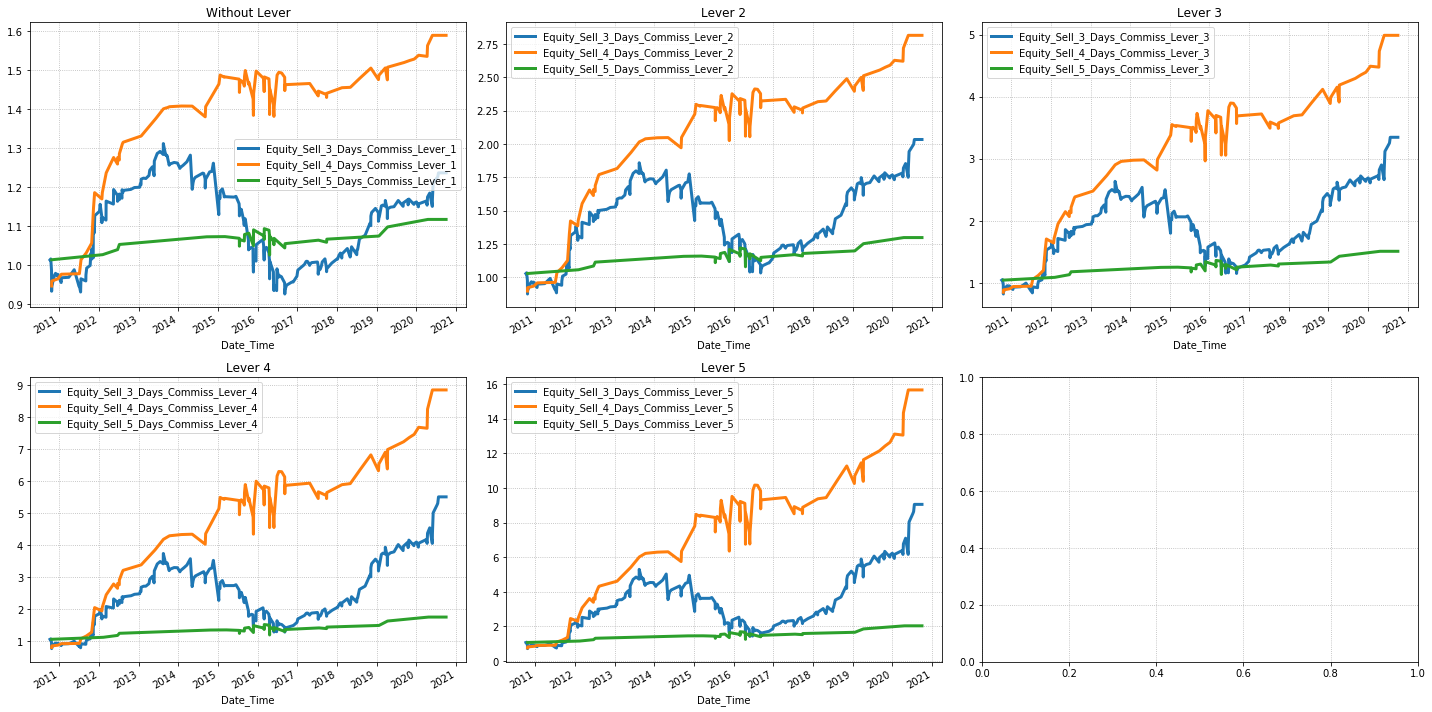

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
df[[
    #'Equity_Sell_1_Days_Commiss_Lever_1',
    #'Equity_Sell_2_Days_Commiss_Lever_1',
    'Equity_Sell_3_Days_Commiss_Lever_1',
    'Equity_Sell_4_Days_Commiss_Lever_1',
    'Equity_Sell_5_Days_Commiss_Lever_1'
]].interpolate(method='index').plot(ax=ax[0,0], title='Without Lever')
df[[
    #'Equity_Sell_1_Days_Commiss_Lever_2',
    #'Equity_Sell_2_Days_Commiss_Lever_2',
    'Equity_Sell_3_Days_Commiss_Lever_2',
    'Equity_Sell_4_Days_Commiss_Lever_2',
    'Equity_Sell_5_Days_Commiss_Lever_2'
]].interpolate(method='index').plot(ax=ax[0,1], title='Lever 2')
df[[
    #'Equity_Sell_1_Days_Commiss_Lever_3',
    #'Equity_Sell_2_Days_Commiss_Lever_3',
    'Equity_Sell_3_Days_Commiss_Lever_3',
    'Equity_Sell_4_Days_Commiss_Lever_3',
    'Equity_Sell_5_Days_Commiss_Lever_3'
]].interpolate(method='index').plot(ax=ax[0,2], title='Lever 3')
df[[
    #'Equity_Sell_1_Days_Commiss_Lever_4',
    #'Equity_Sell_2_Days_Commiss_Lever_4',
    'Equity_Sell_3_Days_Commiss_Lever_4',
    'Equity_Sell_4_Days_Commiss_Lever_4',
    'Equity_Sell_5_Days_Commiss_Lever_4'
]].interpolate(method='index').plot(ax=ax[1,0], title='Lever 4')
df[[
    #'Equity_Sell_1_Days_Commiss_Lever_5',
    #'Equity_Sell_2_Days_Commiss_Lever_5',
    'Equity_Sell_3_Days_Commiss_Lever_5',
    'Equity_Sell_4_Days_Commiss_Lever_5',
    'Equity_Sell_5_Days_Commiss_Lever_5'
]].interpolate(method='index').plot(ax=ax[1,1], title='Lever 5')
plt.tight_layout()
plt.savefig('../src/sell_leverage.png')

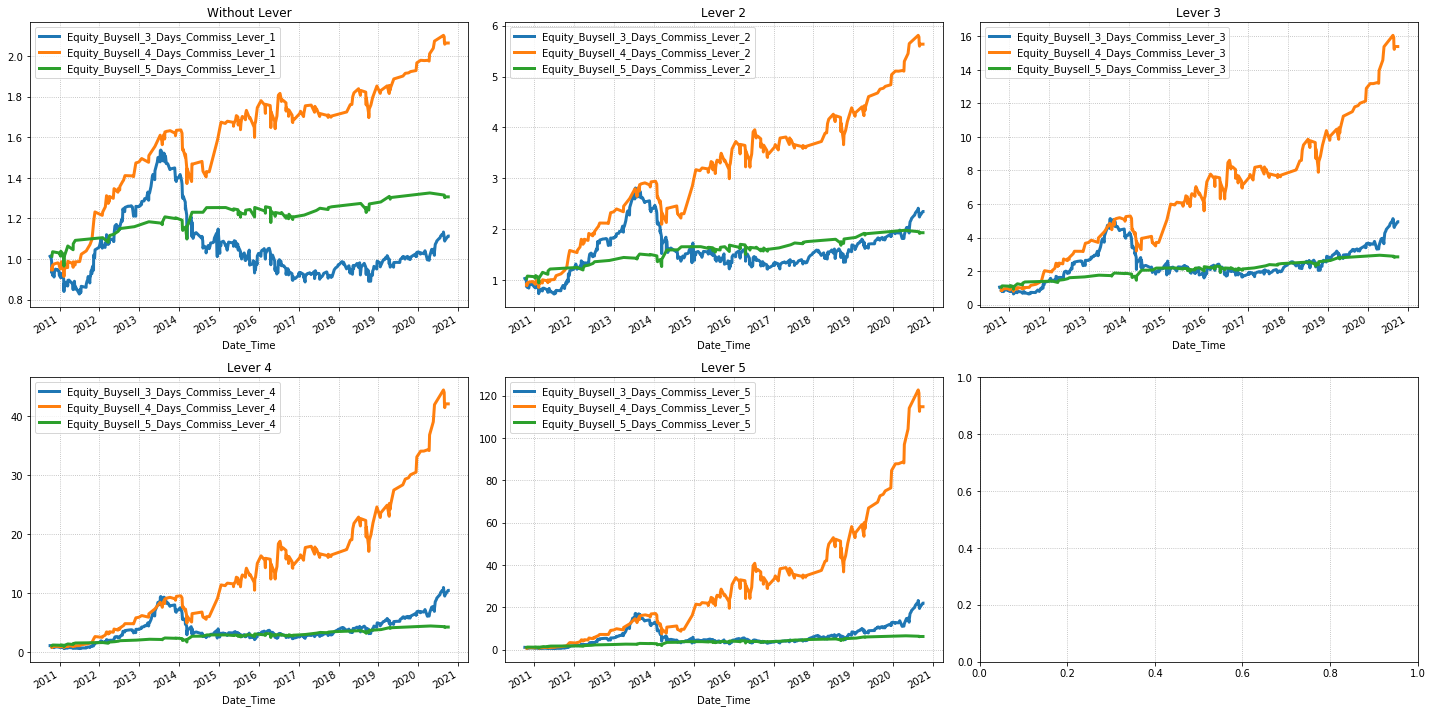

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
df[[
    #'Equity_Buysell_1_Days_Commiss_Lever_1',
    #'Equity_Buysell_2_Days_Commiss_Lever_1',
    'Equity_Buysell_3_Days_Commiss_Lever_1',
    'Equity_Buysell_4_Days_Commiss_Lever_1',
    'Equity_Buysell_5_Days_Commiss_Lever_1'
]].interpolate(method='index').plot(ax=ax[0,0], title='Without Lever')
df[[
    #'Equity_Buysell_1_Days_Commiss_Lever_2',
    #'Equity_Buysell_2_Days_Commiss_Lever_2',
    'Equity_Buysell_3_Days_Commiss_Lever_2',
    'Equity_Buysell_4_Days_Commiss_Lever_2',
    'Equity_Buysell_5_Days_Commiss_Lever_2'
]].interpolate(method='index').plot(ax=ax[0,1], title='Lever 2')
df[[
    #'Equity_Buysell_1_Days_Commiss_Lever_3',
    #'Equity_Buysell_2_Days_Commiss_Lever_3',
    'Equity_Buysell_3_Days_Commiss_Lever_3',
    'Equity_Buysell_4_Days_Commiss_Lever_3',
    'Equity_Buysell_5_Days_Commiss_Lever_3'
]].interpolate(method='index').plot(ax=ax[0,2], title='Lever 3')
df[[
    #'Equity_Buysell_1_Days_Commiss_Lever_4',
    #'Equity_Buysell_2_Days_Commiss_Lever_4',
    'Equity_Buysell_3_Days_Commiss_Lever_4',
    'Equity_Buysell_4_Days_Commiss_Lever_4',
    'Equity_Buysell_5_Days_Commiss_Lever_4'
]].interpolate(method='index').plot(ax=ax[1,0], title='Lever 4')
df[[
    #'Equity_Buysell_1_Days_Commiss_Lever_5',
    #'Equity_Buysell_2_Days_Commiss_Lever_5',
    'Equity_Buysell_3_Days_Commiss_Lever_5',
    'Equity_Buysell_4_Days_Commiss_Lever_5',
    'Equity_Buysell_5_Days_Commiss_Lever_5'
]].interpolate(method='index').plot(ax=ax[1,1], title='Lever 5')
plt.tight_layout()
plt.savefig('../src/buysell_leverage.png')